In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = 'test'

In [3]:
# Load your CSV
df = pd.read_csv(f"../results/{dataset}.csv")

# Take log of mse first
df['log_mse'] = np.log10(df['mse'])

subsets = df['subset'].unique()
categories = df['category'].unique()
models = df['model'].unique()

In [4]:
# Aggregate by subset, category, model
df_mean = df.groupby(['subset', 'category', 'model'], sort=False).agg(mse_mean=('log_mse', 'mean'), mse_sd=('log_mse', 'std')).reset_index()

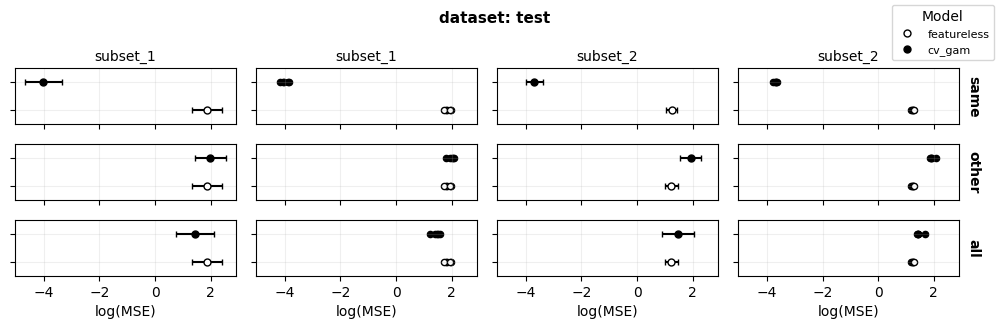

In [5]:
fig, axes = plt.subplots(
    len(categories),
    len(subsets) * 2,
    figsize=(5 * len(subsets), 1.1 * len(categories)),
    sharex=True
)

for i, category in enumerate(categories):
    for j in range(len(subsets) * 2):
        subset = subsets[j // 2]
        ax_err = axes[i, j]
        ax_err.grid(alpha=0.2)

        data_mean = df_mean[(df_mean['category'] == category) & (df_mean['subset'] == subset)]
        data = df[(df['category'] == category) & (df['subset'] == subset)]

        model_names = data['model'].unique()
        model_to_y = {m: yk for yk, m in enumerate(model_names)}
        
        ax_err.set_ylim(-0.5, len(models) - 0.5)

        if i == len(categories) - 1:
            ax_err.set_xlabel('log(MSE)')
        if i == 0:
            ax_err.set_title(f'{subset}', fontsize=10)

        ax_err.set_yticklabels([])
        if j == 2*len(subsets) - 1:
            ax_err.set_ylabel(category, rotation=-90, labelpad=15, va='center', fontweight='bold')
            ax_err.yaxis.set_label_position('right')

        if j % 2 == 0:
            for k, row in enumerate(data_mean.itertuples()):
                if row.model == 'featureless':
                    ax_err.errorbar(row.mse_mean, k, xerr=5*row.mse_sd, fmt='o', color='black', markerfacecolor='white', capsize=2, markersize=5)
                elif row.model == 'cv_gam':
                    ax_err.errorbar(row.mse_mean, k, xerr=5*row.mse_sd, fmt='o', color='black', markerfacecolor='black', capsize=2, markersize=5)
        else:
            for model in model_names:
                vals = data.loc[data['model'] == model, 'log_mse']
                y_pos = model_to_y[model]
                if model == 'featureless':
                    ax_err.scatter(vals, np.ones_like(vals)*y_pos, facecolor='white', edgecolor='black', s=20)
                elif model == 'cv_gam':
                    ax_err.scatter(vals, np.ones_like(vals)*y_pos, facecolor='black', edgecolor='black', s=20)

# Create a global legend using dummy plots
handles = [
    plt.Line2D([], [], marker='o', color='black', markerfacecolor='white', linestyle='', markersize=5, label='featureless'),
    plt.Line2D([], [], marker='o', color='black', markerfacecolor='black', linestyle='', markersize=5, label='cv_gam')
]
fig.legend(handles=handles, title='Model', loc='upper right', fontsize=8)
fig.suptitle(f'dataset: {dataset}', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig(f"../figures/{dataset}.png")